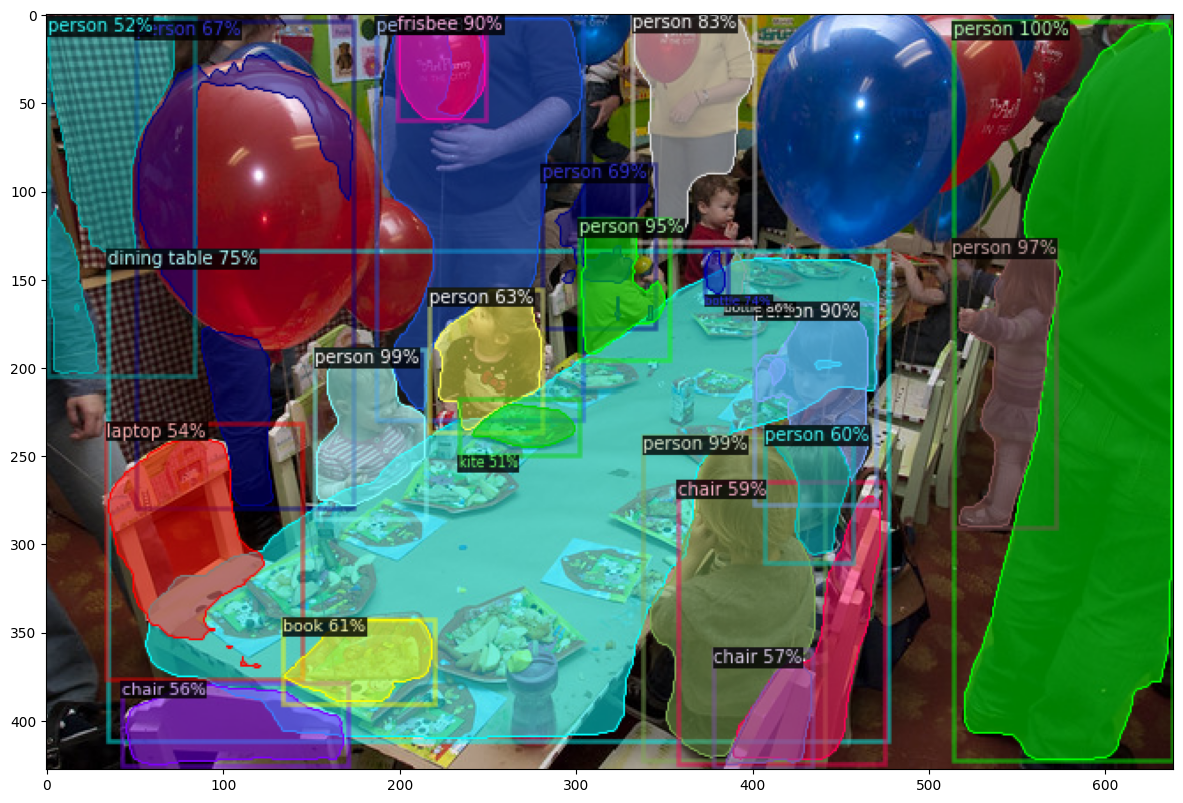

In [6]:
import os
import cv2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
plt.figure(figsize=(15, 10), dpi=100)
import numpy as np
scroll = 0


MODEL_NAME = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
RESULT_DIR = 'results'
DATA_PATH = 'out_of_context'

if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

setup_logger()
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file(MODEL_NAME))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL_NAME)
predictor = DefaultPredictor(cfg)

for image in os.listdir(DATA_PATH):
    img_path = os.path.join(DATA_PATH, image)

    output_path = os.path.join(RESULT_DIR, image)
    
    im = cv2.imread(img_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    cv2.imwrite('composite.png', im) 
    cv2.imwrite('composite2.png', im) 
    outputs = predictor(im)
    v = Visualizer(
        im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
    img = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    imshow(img.get_image()[:, :, ::-1])
    mask= outputs['instances'].get('pred_boxes')
    mask= mask.to('cpu')

    break

In [7]:
from PIL import Image
import numpy

masks = np.asarray(outputs["instances"].pred_masks.to("cpu"))
angle = 90
def select_mask(im,num_mask=1):
    masks = np.asarray(outputs["instances"].pred_masks.to("cpu"))
    item_mask = masks[num_mask]

    segmentation = np.where(item_mask == True)
    x_min = int(np.min(segmentation[1]))
    x_max = int(np.max(segmentation[1]))
    y_min = int(np.min(segmentation[0]))
    y_max = int(np.max(segmentation[0]))
    print(x_min, x_max, y_min, y_max)

    cropped = Image.fromarray(im[y_min:y_max, x_min:x_max, :], mode='RGB')
    mask = Image.fromarray((item_mask * 255).astype('uint8'))
    cropped_mask = mask.crop((x_min, y_min, x_max, y_max))
    background = Image.fromarray(im, mode='RGB')

    composite = background
    return cropped,cropped_mask,composite

def copy_image(var_background,var_cropped_img,var_cropped_mask,x,y,rotate):
    angle = rotate
    paste_position = (x, y)

    new_fg_image = Image.new('RGB', var_background.size)
    var_cropped_img = Image.fromarray(numpy.uint8(var_cropped_img))
    width, height = var_cropped_img.size
    (cw,ch) = (width//2, height//2)
    var_cropped_img = var_cropped_img.rotate(angle, expand = True,center=(cw,ch))
    paste_position = (x-cw,y-ch)
    new_fg_image.paste(var_cropped_img, paste_position)

    new_alpha_mask = Image.new('L', var_background.size, color = 0)
    var_cropped_mask = Image.fromarray(numpy.uint8(var_cropped_mask))
    var_cropped_mask = var_cropped_mask.rotate(angle, expand= True,center=(cw,ch))
    new_alpha_mask.paste(var_cropped_mask, paste_position)

    composite = Image.composite(new_fg_image, var_background, new_alpha_mask)
    composite = numpy.array(composite) 
    
    composite = composite[:, :, ::-1].copy() 
    return composite


In [8]:
# Creating mouse callback function  

def draw_circle(event,x,y,flags,param):  
    global angle
    global scroll
    global cropped
    global cropped_mask
    global composite
    composite = Image.open('composite.png')
    composite = composite.convert('RGB')
    composite2 = Image.open('composite2.png')
    composite2 = composite2.convert('RGB')
    
    if (event == cv2.EVENT_MOUSEWHEEL):
        if flags > 0: 
            scroll = scroll + 1
            cropped,cropped_mask,composite = select_mask(im,scroll)
        else:
            scroll = scroll - 1
            cropped,cropped_mask,composite = select_mask(im,scroll)

    if(event == cv2.EVENT_LBUTTONDBLCLK):  
            composite = copy_image(composite2,cropped,cropped_mask,x,y,angle)
            cv2.imwrite('composite2.png', composite) 

    if (event == cv2.EVENT_RBUTTONDBLCLK):
        if angle <= 360:
            angle = angle + 30
            print(angle)
        else:
            angle = 0
            print('0')
    if(event == cv2.EVENT_MOUSEMOVE):  
            composite = copy_image(composite2,cropped,cropped_mask,x,y,angle)
            cv2.imwrite('composite.png',composite) 





# Creating a black image, a window and bind the function to window  
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
cropped,cropped_mask,composite = select_mask(im,1)
cropped.convert('RGB')
cropped_mask.convert('RGB')
composite.convert('RGB')
cv2.namedWindow('image')  
cv2.setMouseCallback('image',draw_circle)

while(1):  
    composite = cv2.imread('composite.png') 
    composite = cv2.cvtColor(composite, cv2.COLOR_BGR2RGB)
    cv2.imshow('image',composite)  
    if cv2.waitKey(20) & 0xFF == 27:  
        break  
cv2.destroyAllWindows()  

342 435 239 421
342 435 239 421
153 214 190 278
120
150
180
190 303 2 224
517 571 129 290
210


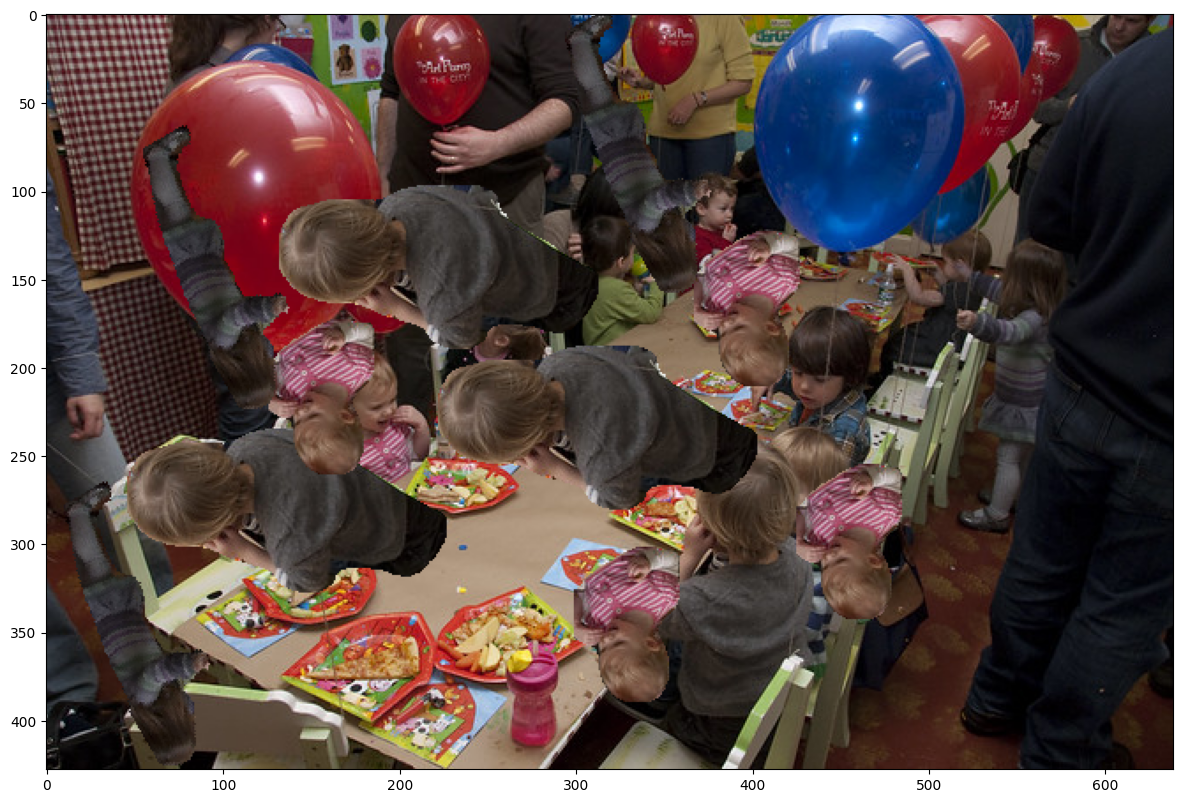

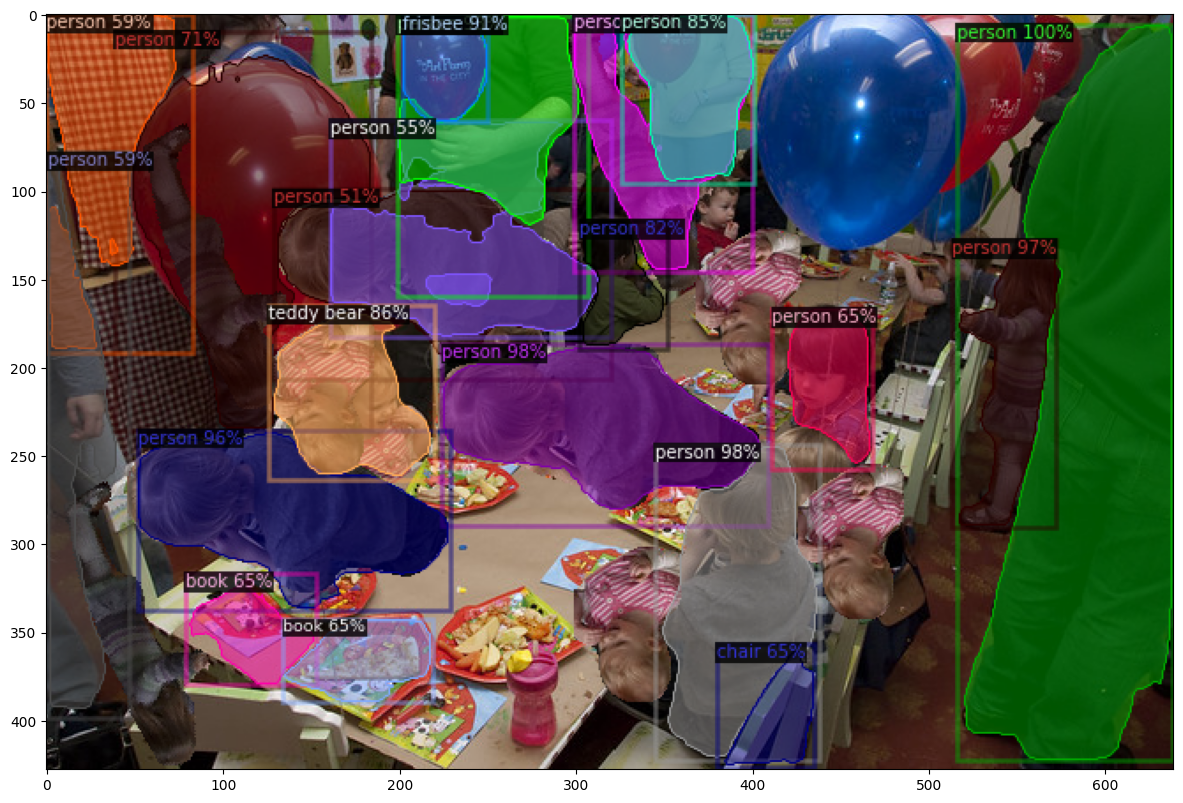

In [9]:
from IPython.display import Image
from IPython.display import display

plt.figure(figsize=(15, 10), dpi=100)
composite = cv2.imread('composite.png') 
#composite = cv2.cvtColor(composite, cv2.COLOR_BGR2RGB)
imshow(composite)  


img_path = 'composite.png'

output_path = os.path.join(RESULT_DIR, image)

# Read image
im = cv2.imread(img_path)
imshow(im)
plt.show()
# Forward pass
outputs = predictor(im)
plt.figure(figsize=(15, 10), dpi=100)
# Save to disk
v = Visualizer(
    im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
img = v.draw_instance_predictions(outputs["instances"].to("cpu"))
imshow(img.get_image()[:, :, ::-1])
plt.show()

mask= outputs['instances'].get('pred_boxes')
mask= mask.to('cpu')


